# Выборка и агрегация данных в MongoDB

### Цель домашней работы

Закрепить на практике основные приемы работы с СУБД MongoDB, включая выборку, сортировку, объединение, агрегацию данных и передачу результатов выборки в программу на Python в целях аналитики и дальнейшей обработки.

### Условия выполнения задания

В этом задании вам предстоит выполнить несколько запросов к базе данных для получения выборок по условиям, а также воспользоваться фреймворком агрегации MongoDB для построения конвейера обработки данных.

**Максимальное количество баллов за выполнение домашней работы:** 10.

## Как выполнять задание

В работе над заданием нужно использовать следующие инструменты:

* **MongoDB:**

1. Зарегистрируйтесь в сервисе MongoDB Atlas: https://www.mongodb.com/atlas/database.
1. Создайте кластер уровня M0 — это бесплатно.
1. Добавьте в кластер тестовую базу данных `sample_mflix`, используя опцию Load Sample Dataset.

В качестве альтернативы вы можете установить MongoDB на свой локальный компьютер и импортировать необходимые датасеты в свою СУБД, загрузив их по ссылке: https://github.com/neelabalan/mongodb-sample-dataset/tree/main/sample_mflix. Для этого подключитесь к своему серверу через Compass, создайте новую БД, создайте для каждого датасета коллекцию и щелкните Add data → Import JSON or CSV file.

* **MongoDB Compass** — графический интерфейс для работы с MongoDB, который можно использовать как вспомогательный инструмент при создании запросов и построении агрегаций.

* **Python и библиотека PyMongo.** Работайте в Jupyter Notebook или Google Colaboratory. Рекомендуется использовать версию Python 3.12.

## Формат сдачи

Результаты работы необходимо оформить в виде ноутбука Jupyter. Можно загрузить файл в LMS либо поделиться ссылкой на Google Colaboratory.

## Место, где нужно выполнить задание



#### **Пошаговая установка MongoDB на Linux Ubuntu**
 1. Через официальный репозиторий MongoDB:
  * Импортируем ключ GPG MongoDB: 

    `wget -qO - https://www.mongodb.org/static/pgp/server-7.0.asc | sudo apt-key add -`

  * Добавляем репозиторий MongoDB в список репозиторий Linux:
  
    `echo "deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/7.0 multiverse" | sudo tee /etc/apt/sources.list.d/mongodb-org-7.0.list`

  * Обновляем список пакетов

    `sudo apt update`

  * Устанавливаем MongoDB

    `sudo apt install mongodb-org`
  
  * Проверяем версию

    `mongod --version`
  
  * Запускаем MongoDB

    `sudo systemctl start mongod`
  
  * Включаем автозапуск

    `sudo systemctl enable mongod`

  * Перезапускаем службу

    `sudo systemctl restart mongod`

Удаляем в обратном порядке.


In [1]:
# Получить модуль `pymongo` для работы с MongoDB в Python

!pip install pymongo



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# Импорт необходимых модулей

import pymongo as pm
import seaborn as sns


Для создания БД MongoDB, необходимой для выполнения задания, были использованы датасеты [`comments.json` `movies.json` `sessions.json` `theaters.json` `users.json`], расположенные в репозитории GitHub: https://github.com/neelabalan/mongodb-sample-dataset/tree/main/sample_mflix

Чтобы загрузить датасеты в БД MongoDB воспользуемся приложением `MongoDB Compass`: `https://www.mongodb.com/try/download/compass`:

В `MongoDB Compass` на Windows подключаемся к WSL через localhost и создаем БД `sample_mflix`; загружаем в `sample_mflix` коллекции [`comments.json` `movies.json` `sessions.json` `theaters.json` `users.json`]

In [3]:
# Проверка, что сервер БД MongoDB запущен

!systemctl status mongod


● mongod.service - MongoDB Database Server
     Loaded: loaded (]8;;file://acer-wsl/lib/systemd/system/mongod.service/lib/systemd/system/mongod.service]8;;; enabled; vendor preset: enabled)
     Active: active (running) since Wed 2025-12-03 10:27:09 MSK; 1h 20min ago
       Docs: ]8;;https://docs.mongodb.org/manualhttps://docs.mongodb.org/manual]8;;
   Main PID: 203 (mongod)
     Memory: 266.2M
        CPU: 1min 3.989s
     CGroup: /system.slice/mongod.service
             └─203 /usr/bin/mongod --config /etc/mongod.conf

Dec 03 10:27:09 acer-wsl systemd[1]: Started MongoDB Database Server.
Dec 03 10:27:09 acer-wsl mongod[203]: {"t":{"$date":"2025-12-03T07:27:09.66…se"}
Hint: Some lines were ellipsized, use -l to show in full.


In [4]:
# Подключение к БД MongoDB

client = pm.MongoClient("mongodb://localhost:27017")
client


MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [5]:
# Вывод списка БД в MongoDB для проверки подключения

print(  # Вывести 
    "Availabel DB's:",
    client.list_database_names()
)


Availabel DB's: ['admin', 'config', 'local', 'sample_mflix']


In [6]:
# Вывод коллекции, необходимой для выполнения задания 


sample_mflix = client['sample_mflix']
print(
    "Avalabel collections:",
    sample_mflix.list_collection_names()
)


Avalabel collections: ['sessions', 'theaters', 'comments', 'users', 'movies']


### Упражнение 1. Запросы на выборку

Цель этого упражнения — закрепить навык выполнения запросов на выборку. Все запросы выполняются на базе `sample_mflix` с данными о кинофильмах.

#### Задача 1.1 (1 балл)

Выведите из коллекции `theaters` документы о кинотеатрах в городе Florence, штат KY.

**Для справки:**

* Обратите внимание, что информация об адресе кинотеатров хранится во вложенных документах. Для доступа к полям вложенных документов следует использовать точку: `родительский_документ.вложенный_документ.поле`.
* В случае затруднений с написанием логического условия обращайтесь к сопоставлению синтаксиса SQL и Mongo: https://www.mongodb.com/docs/manual/reference/sql-comparison/.
* Если вы предпочитаете сперва выполнять запросы в Compass, из этого приложения можно выгружать код готового запроса на Python (кнопка с символом `</>`).

In [7]:
# Ваш код здесь

q_result_1 = sample_mflix.theaters.find(
    {
        "location.address.city": "Florence",
        "location.address.state": "KY"
    },
)

q_result_1.to_list()


[{'_id': ObjectId('59a47287cfa9a3a73e51e893'),
  'theaterId': 161,
  'location': {'address': {'street1': '100 Meijer Dr.',
    'city': 'Florence',
    'state': 'KY',
    'zipcode': '41042'},
   'geo': {'type': 'Point', 'coordinates': [-84.636383, 39.014843]}}},
 {'_id': ObjectId('59a47287cfa9a3a73e51ea02'),
  'theaterId': 2823,
  'location': {'address': {'street1': '2823 Florence Mall',
    'street2': '#2148',
    'city': 'Florence',
    'state': 'KY',
    'zipcode': '41042'},
   'geo': {'type': 'Point', 'coordinates': [-84.6499595, 38.9967246]}}}]

#### Задача 1.2 (1 балл)

Сделайте запрос к коллекции `comments` и выведите один комментарий (значение поля `text`) пользователя по имени Doreah.

In [8]:
# Ваш код здесь

q_result_2 = sample_mflix.comments.find_one(
    {
        "name": "Doreah"
    },
)

q_result_2.get("text", "No comments")


'Porro explicabo cumque vitae sint quia quis. Consequuntur voluptatibus optio maxime ratione temporibus incidunt minus architecto.'

#### Задача 1.3 (1 балл)

Сделайте запрос к коллекции `movies` и выведите количество документов, в которых в качестве первого жанра фильма (поле `genres`) указано значение Horror.

**Для справки:**

1. Обратите внимание, что поле `genres` представляет собой массив (индексация массивов начинается с нуля).
1. При работе в MongoDB Shell для подсчета количества документов в курсоре можно использовать метод `count()`, однако он был удален в последних версиях библиотеки PyMongo. В случае затруднений с использованием функций Mongo можно использовать для подсчета документов средства Python.

In [9]:
# Ваш код здесь

q_result_3 = sample_mflix.movies.find(
    {
        "genres.0": "Horror"
    },
)

len(q_result_3.to_list())


814

#### Задача 1.4 (2 балла)

Выведите из коллекции `movies` документы о фильмах, которые в качестве первого жанра определены как Film-Noir либо Horror и были выпущены в период с 1940 по 1949 г. (включительно).

In [10]:
# Ваш код здесь

q_result_4 = sample_mflix.movies.find(
    {
        "$or": [
            {"genres.0": "Film-Noir"},
            {"genres.0": "Horror"}
        ],
        "year": {"$gte": 1940, "$lte": 1949},
    },
)

q_result_4.to_list()


[{'_id': ObjectId('573a1393f29313caabcdc814'),
  'plot': "An American man marries a Serbian immigrant who fears that she will turn into the cat person of her homeland's fables if they are intimate together.",
  'genres': ['Horror', 'Thriller'],
  'runtime': 73,
  'rated': 'APPROVED',
  'cast': ['Simone Simon', 'Kent Smith', 'Tom Conway', 'Jane Randolph'],
  'poster': 'https://m.media-amazon.com/images/M/MV5BNzI4YWY0NWQtNWI5YS00MGE4LWE4YTgtMzBmOWIwMzdiYTRiL2ltYWdlL2ltYWdlXkEyXkFqcGdeQXVyNjc1NTYyMjg@._V1_SY1000_SX677_AL_.jpg',
  'title': 'Cat People',
  'fullplot': 'Irena Dubrovna, a beautiful and mysterious Serbian-born fashion artist living in New York City, falls in love with and marries average-Joe American Oliver Reed. Their marriage suffers though, as Irena believes that she suffers from an ancient curse- whenever emotionally aroused, she will turn into a panther and kill. Oliver thinks that is absurd and childish, so he sends her to psychiatrist Dr. Judd to cure her. Easier said t

#### Задача 1.5 (1 балл)

Модифицируйте запрос из задачи 1.4 таким образом, чтобы осуществить **проекцию**: результатом выборки должен стать список словарей, каждый из которых содержит только два поля: `title` и `year`.

Для справки о проекции смотрите документацию по методу `find()` в PyMongo:
https://pymongo.readthedocs.io/en/stable/api/pymongo/collection.html#pymongo.collection.Collection.find

In [11]:
# Ваш код здесь

q_result_5 = sample_mflix.movies.find(
    {
        "$or": [
            {"genres.0": "Film-Noir"},
            {"genres.0": "Horror"}
        ],
        "year": {"$gte": 1940, "$lte": 1949},
    },
    {
        "_id": False,  # 0
        "title": True,  # 1
        "year": True,  # 1
    },
)

q_result_5.to_list()


[{'title': 'Cat People', 'year': 1942},
 {'title': 'I Walked with a Zombie', 'year': 1943},
 {'title': 'The Leopard Man', 'year': 1943},
 {'title': 'The Body Snatcher', 'year': 1945},
 {'title': 'Dead of Night', 'year': 1945},
 {'title': 'Spellbound', 'year': 1945},
 {'title': 'The Chase', 'year': 1946},
 {'title': 'The Set-Up', 'year': 1949},
 {'title': 'The Third Man', 'year': 1949}]

### Упражнение 2. Агрегация с помощью конвейеров

#### Задача 2.1 (3 балла)

В этой задаче вам требуется определить, какие фильмы получили наибольшее количество комментариев. Составьте для этого конвейер агрегации с перечисленными ниже этапами. Для удобства рекомендуется воспользоваться приложением Compass.

**Этапы выполнения задания:**

1. Сгруппировать документы коллекции `comments` по полю `movie_id` и подсчитать количество комментариев для каждого фильма, записав его в поле `count`.
1. Отсортировать получившийся набор данных по убыванию количества комментариев (так, чтобы первый документ в этом наборе указывал на фильм с наибольшим количеством комментариев).
1. Используя оператор `$lookup`, присоединить коллекцию `movies` (по полю `movie_id`).
1. Выполнить проекцию, оставив в наборе данных только три поля: название фильма (`title`), год выпуска (`year`) и количество комментариев (поле `count`, добавленное на первом этапе). Для этого воспользуйтесь оператором `$project`: https://www.mongodb.com/docs/manual/reference/operator/aggregation/project/. Обратите внимание, что данные из коллекции `movies` (`title` и `year`) на этом этапе окажутся внутри массива.
1. Применить оператор `$unwind`, чтобы деконструировать этот массив (подробнее на https://www.mongodb.com/docs/manual/reference/operator/aggregation/unwind/). В результате массив должен превратиться в одиночный объект.
1. Применить оператор `$addFields`, чтобы добавить поля `title` и `year` на верхний уровень структуры документа (https://www.mongodb.com/docs/manual/reference/operator/aggregation/addFields/).
1. Выполнить проекцию еще раз, чтобы удалить поле с массивом.

Ваш алгоритм решения может отличаться от приведенного здесь. Главное — достичь цели: **получить плоский набор данных с тремя полями** (`count` — количество комментариев, `year` — год выпуска, `title` — название фильма).

Скопируйте полученный конвейер в этот документ в виде кода на Python и выведите его на экран в виде списка словарей.

In [12]:
# Ваш код здесь

pipeline = [
    {
        "$group": {"_id": "$movie_id",
                   "count": {"$sum": 1}}
    },
    {
        "$sort": {"count": -1}
    },
    {
        "$lookup": {"from": "movies",
                    "localField": "_id",
                    "foreignField": "_id",
                    "as": "total_movies"}
    },
    {
        "$unwind": "$total_movies"
    },
    {
        "$project": {"_id": False,  # 0
                     "count": True,  # 1
                     "title": "$total_movies.title",
                     "year": "$total_movies.year"}
    },
]

q_result_6 = sample_mflix.comments.aggregate(pipeline=pipeline)

q_result_6.to_list()


[{'count': 161, 'title': 'The Taking of Pelham 1 2 3', 'year': 2009},
 {'count': 158, 'title': '50 First Dates', 'year': 2004},
 {'count': 158, 'title': 'About a Boy', 'year': 2002},
 {'count': 158, 'title': "Ocean's Eleven", 'year': 2001},
 {'count': 158, 'title': 'Terminator Salvation', 'year': 2009},
 {'count': 157, 'title': 'Sherlock Holmes', 'year': 2009},
 {'count': 157, 'title': 'The Mummy', 'year': 1999},
 {'count': 155, 'title': 'Hellboy II: The Golden Army', 'year': 2008},
 {'count': 154,
  'title': 'Anchorman: The Legend of Ron Burgundy',
  'year': 2004},
 {'count': 154, 'title': 'The Mummy Returns', 'year': 2001},
 {'count': 153, 'title': 'Bruce Almighty', 'year': 2003},
 {'count': 153, 'title': 'Mission: Impossible', 'year': 1996},
 {'count': 153, 'title': 'X-Men', 'year': 2000},
 {'count': 153, 'title': 'Cinderella', 'year': 1950},
 {'count': 153, 'title': 'Wanted', 'year': 2008},
 {'count': 153, 'title': 'E.T. the Extra-Terrestrial', 'year': 1982},
 {'count': 153,
  'tit

In [13]:
pipeline


[{'$group': {'_id': '$movie_id', 'count': {'$sum': 1}}},
 {'$sort': {'count': -1}},
 {'$lookup': {'from': 'movies',
   'localField': '_id',
   'foreignField': '_id',
   'as': 'total_movies'}},
 {'$unwind': '$total_movies'},
 {'$project': {'_id': False,
   'count': True,
   'title': '$total_movies.title',
   'year': '$total_movies.year'}}]

#### Задача 2.2 (1 балл)

Используя данные, полученные в задаче 2.1, выведите на экран столбчатую диаграмму, показывающую топ-20 наиболее комментируемых фильмов. По оси ординат выведите названия этих фильмов (подписи разместите слева диаграммы), по оси абсцисс — количество комментариев.

Для решения задачи можно использовать любую библиотеку, например, Seaborn или Matplotlib.

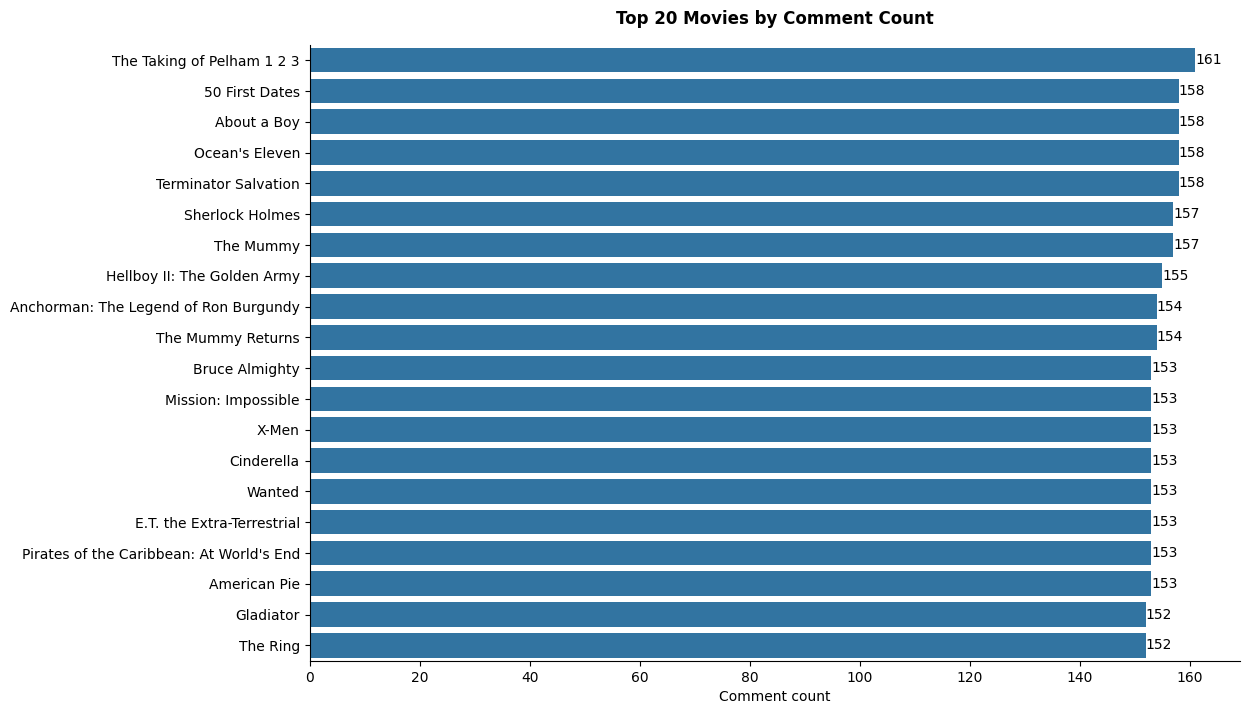

In [14]:
# Ваш код здесь

q_result_7 = sample_mflix.comments.aggregate(pipeline=pipeline).to_list()[:20]

ax = sns.barplot(
    y=[title["title"] for title in q_result_7],
    x=[title["count"] for title in q_result_7],
)

ax.set_title("Top 20 Movies by Comment Count",
             fontsize=12,
             fontweight="bold",
             pad=15)
ax.figure.set_size_inches(12, 8)
ax.set_xlabel("Comment count", fontsize=10)
ax.bar_label(ax.containers[0])
sns.despine();


### Оценка преподавателя

<div style="text-align: center;">
  <img src="./misc/images/review.png" width=1050/>
  <p>Отзыв преподавателя о выполненной работе</p>
</div>
